In [85]:
import h5py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from scipy import constants as cs
import numpy as np
from shabanipy.jj.utils import extract_switching_current
from shabanipy.jj.fraunhofer.dynesfulton import critical_current_density
from shabanipy.jj.fraunhofer.utils import find_fraunhofer_center, symmetrize_fraunhofer
import warnings


PROCESSED_DATA_FILE = 'JS311-MG2_pre-processed_data-198.hdf5'
SAMPLE = '2JJ-2HB-5MGJJ-MG2'
h = h5py.File(PROCESSED_DATA_FILE, 'r')
f = h['IcRn'][f'sample::{SAMPLE}']

In [86]:
PHI0 = cs.h / (2 * cs.e)  # magnetic flux quantum
JJ_WIDTH = 4e-6
# the effective junction length is largely unknown due to thin-film penetration
# depth and flux focusing effects; nominally 100nm
JJ_LENGTH = 1800e-9
FIELD_TO_WAVENUM = 2 * np.pi * JJ_LENGTH / PHI0  # B-field to beta wavenumber
PERIOD = 2 * np.pi / (FIELD_TO_WAVENUM * JJ_WIDTH)

In [87]:
keys = np.array(f)
keys = np.concatenate((keys[-1:],keys[:-1]))
data = {}
bias = {}
dIdV = {}
fft_dIdV = {}
dR = {}
out_field = np.array(f['In-plane Field::0']['Magnet Source - Source current'])

for key in keys:
    data[key] = np.array(f[key]["Voltage Drop"])
    bias[key] = np.array(f[key]["Bias"])
    dR[key] = np.array(f[key]["dR"])
    dIdV[key] = np.diff(np.array(f[key]["Voltage Drop"]))/np.diff(np.array(f[key]["Bias"]))

<ipython-input-64-12664dfd10fb>:35: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(out_field[:,0]/30*1e3, 3*ic/max_ic+n*1.5,  label = f'{key}')


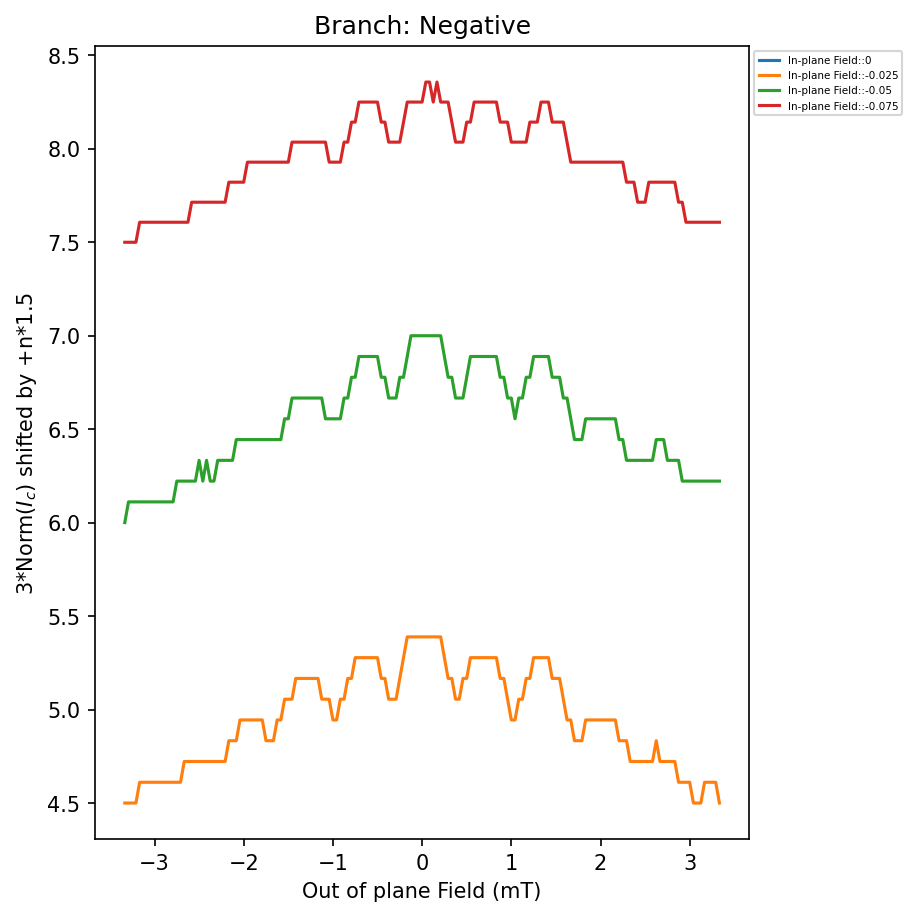

In [64]:
plt.figure(dpi = 150, constrained_layout = True,figsize=(6, 6))

thre = np.array([2.6,2.95,2.95,2.95,2.95,2.95,2.95,3,
                 3.15,3.15,3.15,3.15,
                 3.25,3.25,3.25,3.25,
                 3.5, 3.5, 3.5, 3.8, 3.8])*1e-3

for n, key in enumerate(keys[:4]):
    ic = extract_switching_current(bias[key], data[key], threshold = thre[n], side = "negative")
    max_ic = max(ic)
    plt.plot(out_field[:,0]/30*1e3, 3*ic/max_ic+n*1.5,  label = f'{key}')
    plt.xlabel(r'Out of plane Field (mT)')
    plt.ylabel(r'3*Norm($I_{c}$) shifted by +n*1.5')
    plt.legend(loc = "upper left", prop = {'size' : 5},bbox_to_anchor=(1, 1))
    plt.title('Branch: Negative')
    
    #plt.title(f'{key}')

plt.savefig(f'figs/Ic_N_0.1_all_0.5-198.pdf')

In [60]:
h.close()

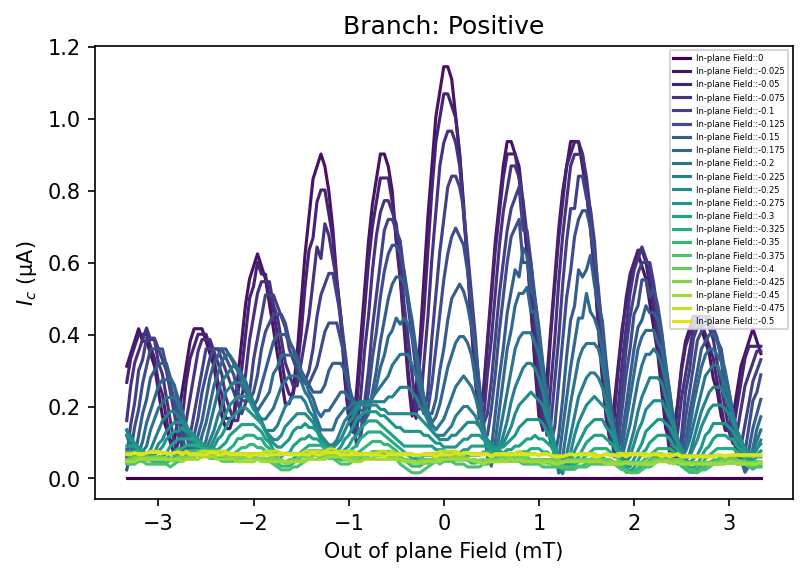

In [88]:
plt.figure(dpi = 150)
cmap = plt.get_cmap("viridis")
for n, key in enumerate(keys):
    ic = extract_switching_current(bias[key], data[key], threshold = thre[n], side = "positive")
    max_ic = max(ic)
    plt.plot(out_field[:,0]/30*1e3, ic*1e6,  label = f'{key}',color = cmap(n/len(keys)))
    plt.xlabel(r'Out of plane Field (mT)')
    plt.ylabel(r'$I_{c}$ (µA)')
    plt.legend(loc = "upper right", prop = {'size' : 4})
    plt.title('Branch: Positive')
plt.savefig(f'figs/Ic_P_0.1_all_0.5_virdis-198.pdf')

<ipython-input-102-a8920bd9159a>:7: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(out_field[:,0]/30*1e3, 6*ic/max(ic)+3*n,  label = f'{key}',color = cmap(n/len(keys)))


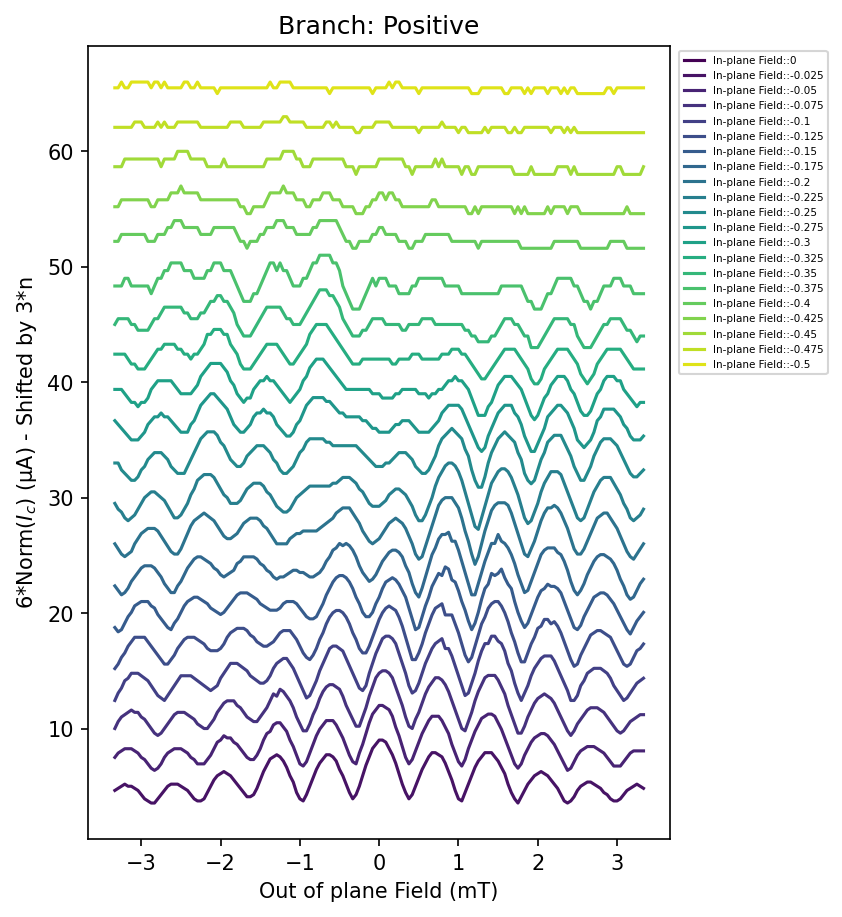

In [102]:
plt.figure(dpi = 150, constrained_layout = True,figsize=(5.5, 6))
cmap = plt.get_cmap("viridis")

for n, key in enumerate(keys):
    ic = extract_switching_current(bias[key], data[key], threshold = thre[n], side = "positive")
    max_ic = max(ic)
    plt.plot(out_field[:,0]/30*1e3, 6*ic/max(ic)+3*n,  label = f'{key}',color = cmap(n/len(keys)))
    plt.xlabel(r'Out of plane Field (mT)')
    #plt.ylabel(r'$I_{c}$ (µA)')
    plt.ylabel(r'6*Norm($I_{c}$) (µA) - Shifted by 3*n')
    plt.legend(loc = "upper right", prop = {'size' : 5},bbox_to_anchor=(1.28, 1))
    plt.title('Branch: Positive')
plt.savefig(f'figs/Ic_P_0.1_all_0.5_virdis_plotNormshifted-198.pdf')